In [497]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [498]:
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


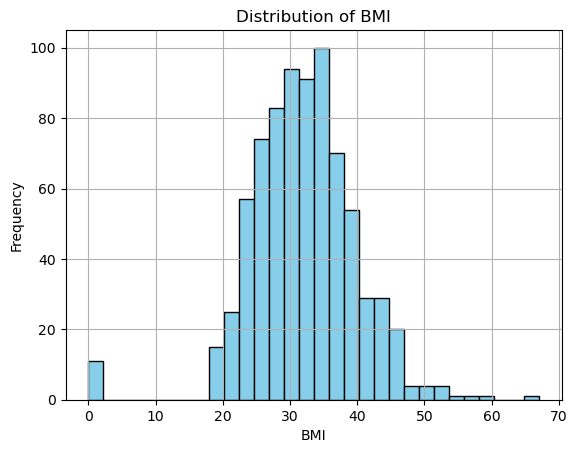

In [499]:
plt.hist(data['BMI'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [500]:
X = data.drop('BMI', axis=1).values
y = data['BMI'].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

In [501]:
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X.shape[1], 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 48),         
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(48, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)
        
model = RegressionNet()
print(model)

RegressionNet(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=48, bias=True)
    (9): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=48, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [502]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [503]:
epochs = 100
patience = 20
best_val_loss = float('inf')
counter = 0
train_losses = []
val_losses = []

import copy
best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    # ---- 학습 단계 ----
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- 검증 단계 ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:  # val_loader는 X_test, y_test에서 만든 DataLoader
            pred = model(val_X)
            loss = criterion(pred, val_y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # ---- Early Stopping 체크 ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        best_model_state = model.state_dict()  # 모델 상태 저장
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# ---- 최적의 모델 불러오기 ----
if best_model_state:
    model.load_state_dict(best_model_state)

Epoch 1/100, Train Loss: 1.0255, Val Loss: 1.0106
Epoch 2/100, Train Loss: 0.8304, Val Loss: 0.8999
Epoch 3/100, Train Loss: 0.7885, Val Loss: 0.8618
Epoch 4/100, Train Loss: 0.7915, Val Loss: 0.8581
Epoch 5/100, Train Loss: 0.6802, Val Loss: 0.8376
Epoch 6/100, Train Loss: 0.7310, Val Loss: 0.8189
Epoch 7/100, Train Loss: 0.7226, Val Loss: 0.8131
Epoch 8/100, Train Loss: 0.7047, Val Loss: 0.7900
Epoch 9/100, Train Loss: 0.6975, Val Loss: 0.8051
Epoch 10/100, Train Loss: 0.6642, Val Loss: 0.8110
Epoch 11/100, Train Loss: 0.7178, Val Loss: 0.7989
Epoch 12/100, Train Loss: 0.6865, Val Loss: 0.7934
Epoch 13/100, Train Loss: 0.6619, Val Loss: 0.7889
Epoch 14/100, Train Loss: 0.7033, Val Loss: 0.7957
Epoch 15/100, Train Loss: 0.6634, Val Loss: 0.7989
Epoch 16/100, Train Loss: 0.6484, Val Loss: 0.7894
Epoch 17/100, Train Loss: 0.6391, Val Loss: 0.8137
Epoch 18/100, Train Loss: 0.6384, Val Loss: 0.8051
Epoch 19/100, Train Loss: 0.6395, Val Loss: 0.8019
Epoch 20/100, Train Loss: 0.6754, Val Lo

In [504]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [505]:
model.eval()
with torch.no_grad():
    pred_scaled = model(X_test_tensor).numpy()
    pred = scaler_y.inverse_transform(pred_scaled)
    true = scaler_y.inverse_transform(y_test_tensor.numpy())

    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)

In [506]:
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

MSE: 48.0701
MAE: 4.9945
R^2 Score: 0.3238


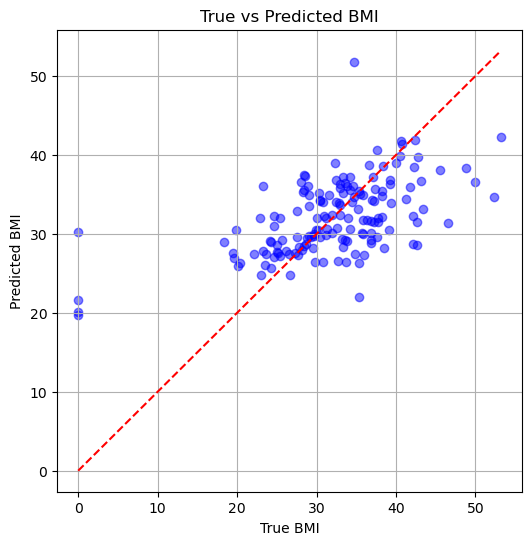

In [507]:
plt.figure(figsize=(6,6))
plt.scatter(true, pred, alpha=0.5, color='blue')
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
plt.xlabel("True BMI")
plt.ylabel("Predicted BMI")
plt.title("True vs Predicted BMI")
plt.grid(True)
plt.show()

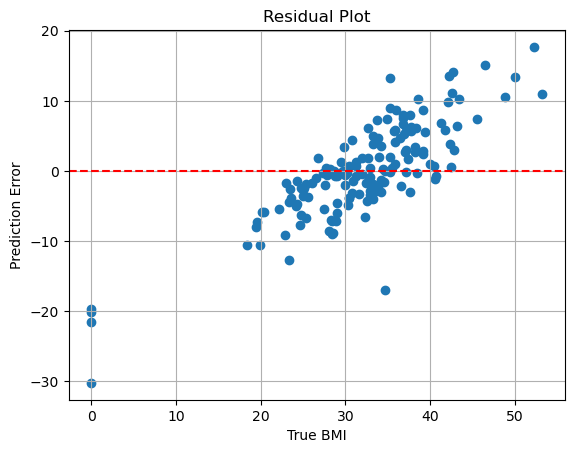

In [520]:
error = true - pred
plt.scatter(true, error)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("True BMI")
plt.ylabel("Prediction Error")
plt.title("Residual Plot")
plt.grid(True)
plt.show()